# Overview


# Tokenization

We will tokenize a protein sequence into its indivisual amino acids. Each amino acid, along with special tokens for the start, end, padding, and unknown symbols, is then assigned a unique integer value.

In [1]:
class Tokenizer:
    def __init__(self):
        # special tokens
        vocab=["<cls>", "<pad>","<eos>","<unk>"]
        # 20 anonical amino acids
        vocab+=list("ACDEFGHIKLMNPQRSTVWY")
        #mapping
        self.token_to_index = {tok: i for i, tok in enumerate(vocab)}
        self.index_to_token = {i: tok for i, tok in enumerate(vocab)}
        
    @property
    def vocab_size(self):
        return len(self.token_to_index)
    
    @property
    def pad_token_id(self):
        return self.token_to_index["<pad>"]
    
    def __call__(self, seqs: list[str], padding: bool = True) -> dict[str, list[list[int]]]:
        """
        Tokenizes a list of protein sequences and creates input representations with attention masks.
        """
        
        input_ids=[]
        attention_mask=[]
        
        if padding:
            max_len=max(len(seq) for seq in seqs)
            
        for seq in seqs:
            # Preprocessing: strip whitespace, convert to uppercase
            seq = seq.strip().upper()

            # Add special tokens
            toks = ["<cls>"] + list(seq) + ["<eos>"]
            
            if padding:
                # Pad with '<pad>' tokens to reach max_len
                toks += ["<pad>"] * (max_len - len(seq))
                
            # Convert tokens to IDs (handling unknown amino acids)
            unk_id = self.token_to_index["<unk>"]
            input_ids.append([self.token_to_index.get(tok, unk_id) for tok in toks])

            # Create attention mask (1 for real tokens, 0 for padding)
            attention_mask.append([1 if tok != "<pad>" else 0 for tok in toks])

        return {"input_ids": input_ids, "attention_mask": attention_mask}

tokenizer=Tokenizer()
print(tokenizer(["ACcA", "AA"], padding=True))
print(tokenizer.vocab_size)
print(tokenizer.pad_token_id)

{'input_ids': [[0, 4, 5, 5, 4, 2], [0, 4, 4, 2, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0]]}
24
1


# Embedding and Positional Encoding

We use an embedding layer to convert the integer values representing out amino acids into vectors of flaoting-point number called embeddings.

## Self-attention

It provides a powerful mechanism for capturing relationships between amino acids within a protein sequence.

Each of these embeddings is then used to generate three new vectors through linear transformation:

* q -> the model focuses on
* k -> used for relevance scoring
* v -> the actual information to be extracted

The scaled dot-product attention formula is as follows:

$$Softmax(\frac{qk^T}{\sqrt{d_k}})V$$

It is used to measure similarity, a higher dot product suggests a stronger relationship between the tokens. And `Softmax` function is applied to the dot products, giving us attention scores.

To improve stability, we scale these dot products by the square root of the embedding dimension(dk). We also have the option to mask out vertain tokens if needed.

Finally, we calcualte a new reoresentation by summing the value vectors(v) of all tokens, weighted by their respective attention scores.

In [2]:
import numpy as np
import torch
import torch.nn as nn

def scale_dot_product_attention(q,k,v, mask=None):
    """
    implement scaled dot product attention, which is essentially softmax(QK.T/sqrt(dk))V
    
    Inputs:
    q: (*, seq_length, dq)
    k: (*, seq_length, dk)
    v: (*, seq_length, dv)
    mask: (*, seq_length, seq_length), optional
    """
    
    attn_logits=(q@k.transpose(-2,-1)/np.sqrt(q.shape[-1]))
    
    if mask is not None:
        attn_logits.masked_fill_(mask==0, -1e9)
        
    # softmax
    attention=torch.softmax(attn_logits, dim=-1)
    
    values=attention@v
    return values, attention


q = torch.randn(16, 32)
k = torch.randn(16, 32)
v = torch.randn(16, 32)

values, attention = scale_dot_product_attention(q, k, v)
assert values.shape == (16, 32)
assert attention.shape == (16, 16)

# Multi Head attention

Multi Head attention employs multiple self-attention mechanisms in parallel, allowing each "head" to focus on different aspects of the input.

This gives the model the ability to capture diverse relationships and nuances within the protein sequence. 

In [3]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_embed):
        """
        d_model: dimensionality of input X
        num_head: number of heads
        d_embed: embedding dimensionality and should be a mutiple of num_head
        """
        
        super().__init__()
        assert(d_embed % num_heads == 0), "Embedding dimensionality and should be a mutiple of num_head"
        
        self.d_model=d_model
        self.num_heads=num_heads
        self.d_head=d_embed//num_heads
        
        # linear for transform X into q,k,v
        self.input=nn.Linear(d_model, 3*d_embed)
        
        # output layer
        self.output=nn.Linear(d_embed, d_embed)

    def expand_mask(self, mask):
        assert 2 <= mask.ndim <= 4, "Wrong mask dimensionality"
        if mask.ndim == 2:
            return mask[:, None, None, :]
        elif mask.ndim == 3:
            return mask[:, None, :, :]
        
    def forward(self, x, mask=None, return_attention=False):
        """
        X: (Batch, seq_len, d_model)
        mask could be either:
            1. None
            2. (batch, seq_len)
            3. (batch, seq_len, seq_len)
            4. (batch, num_head, seq_len, seq_len)
        """

        batch, seq_len = x.shape[0], x.shape[1]

        x = self.input(x)  # (Batch, seq_len, 3 * d_model)

        # split heads
        x = x.reshape(batch, seq_len, self.num_heads, 3 * self.d_head)

        # swap dims
        x = x.permute(0, 2, 1, 3)  # (Batch, head, seq_len, 3 * d_head)

        # q, k, v
        q, k, v = x.chunk(3, dim=-1)  # (Batch, head, seq_len, d_head)

        # expand mask to 4D if needed
        if mask is not None:
            mask = self.expand_mask(mask)

        # values: (batch, head, seq_len, d_head)
        # attention: (batch, head, seq_len, seq_len)
        values, attention = scale_dot_product_attention(q, k, v, mask=mask)

        # change dims
        values = values.permute(0, 2, 1, 3)  # (batch, seq_len, head, d_head)

        # concat heads
        values = values.reshape(batch, seq_len, -1)  # (batch, seq_len, d_embed)

        # output linear layer
        o = self.output(values)  # (batch, seq_len, d_embed)

        if return_attention:
            return o, attention

        return o

d_model, num_head, d_embed = 512, 8, 256 * 8

mha = MultiheadAttention(d_model, num_head, d_embed)
x = torch.randn(16, 1024, d_model)
assert mha(x).shape == (16, 1024, d_embed)

# Encoder Layer and Encoder

It builds upon the multi-head attention implementation to create encoder layers. Each encoder layer includes a multi-head attention mechanism to capture relationships between amino acids within a protein sequence,followed by a fully-connected feed-forward network (FFN) layer for further processing. 

And residual connections and layer normalization techniques are employed within each layer to improve training stability and performance.

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_head, d_ffn, dropout=0.0):
        super().__init__()
        # d_embed is the same as d_model
        self.attention = MultiheadAttention(d_model, num_head, d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ffn),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ffn, d_model),
        )

        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attn_out = self.attention(x, mask)  # (batch, seq_len, d_model)

        # residual connections
        x = x + self.dropout(attn_out)
        # layer norm
        x = self.norm1(x)

        # feed forward
        ffn_out = self.ffn(x)  # (batch, seq_len, d_model)
        x = x + self.dropout(ffn_out)
        x = self.norm2(x)

        return x

x = torch.randn(16, 1024, 512)
encoder_block = EncoderBlock(512, 8, 1024)
assert x.shape == encoder_block(x).shape

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_head, d_ffn, dropout=0.0):
        super().__init__()

        # Encoder consists of a list of EncoderBlocks specified by num_layers
        self.layers = nn.ModuleList(
            [EncoderBlock(d_model, num_head, d_ffn, dropout) for _ in range(num_layers)]
        )

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)

        return x

    def get_attentions(self, x, mask=None):
        """
        Helper function to get attention maps
        """

        attention_maps = []

        for layer in self.layers:
            _, attn = layer.attention(x, mask=mask, return_attention=False)
            attention_maps.append(attn)

            x = layer(x)

        return attention_maps

x = torch.randn(16, 1024, 512)
encoder = Encoder(8, 512, 8, 1024)
assert x.shape == encoder(x).shape

In [6]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, input_dim, max_length=5000):
        super().__init__()

        pe = torch.zeros(max_length, input_dim)

        # add an addtitional dimention for broadcasting
        position = torch.arange(max_length).float().unsqueeze(1)

        # div_term is of length input_dim//2:
        div_term = torch.exp(-torch.arange(0, input_dim, 2) / input_dim * math.log(1e4))

        # position*div_term: (max_length, input_dim//2)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # (max_length, input_dim) => (1, max_length, input_dim)
        pe = pe.unsqueeze(0)

        # pe is not a parameter
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = x + self.pe[:, : x.shape[1], :]
        return x

pe=PositionalEncoding(32)
x=torch.randn(128,10,32)
pe(x).shape

torch.Size([128, 10, 32])

Text(0, 0.5, 'Hidden Dimension')

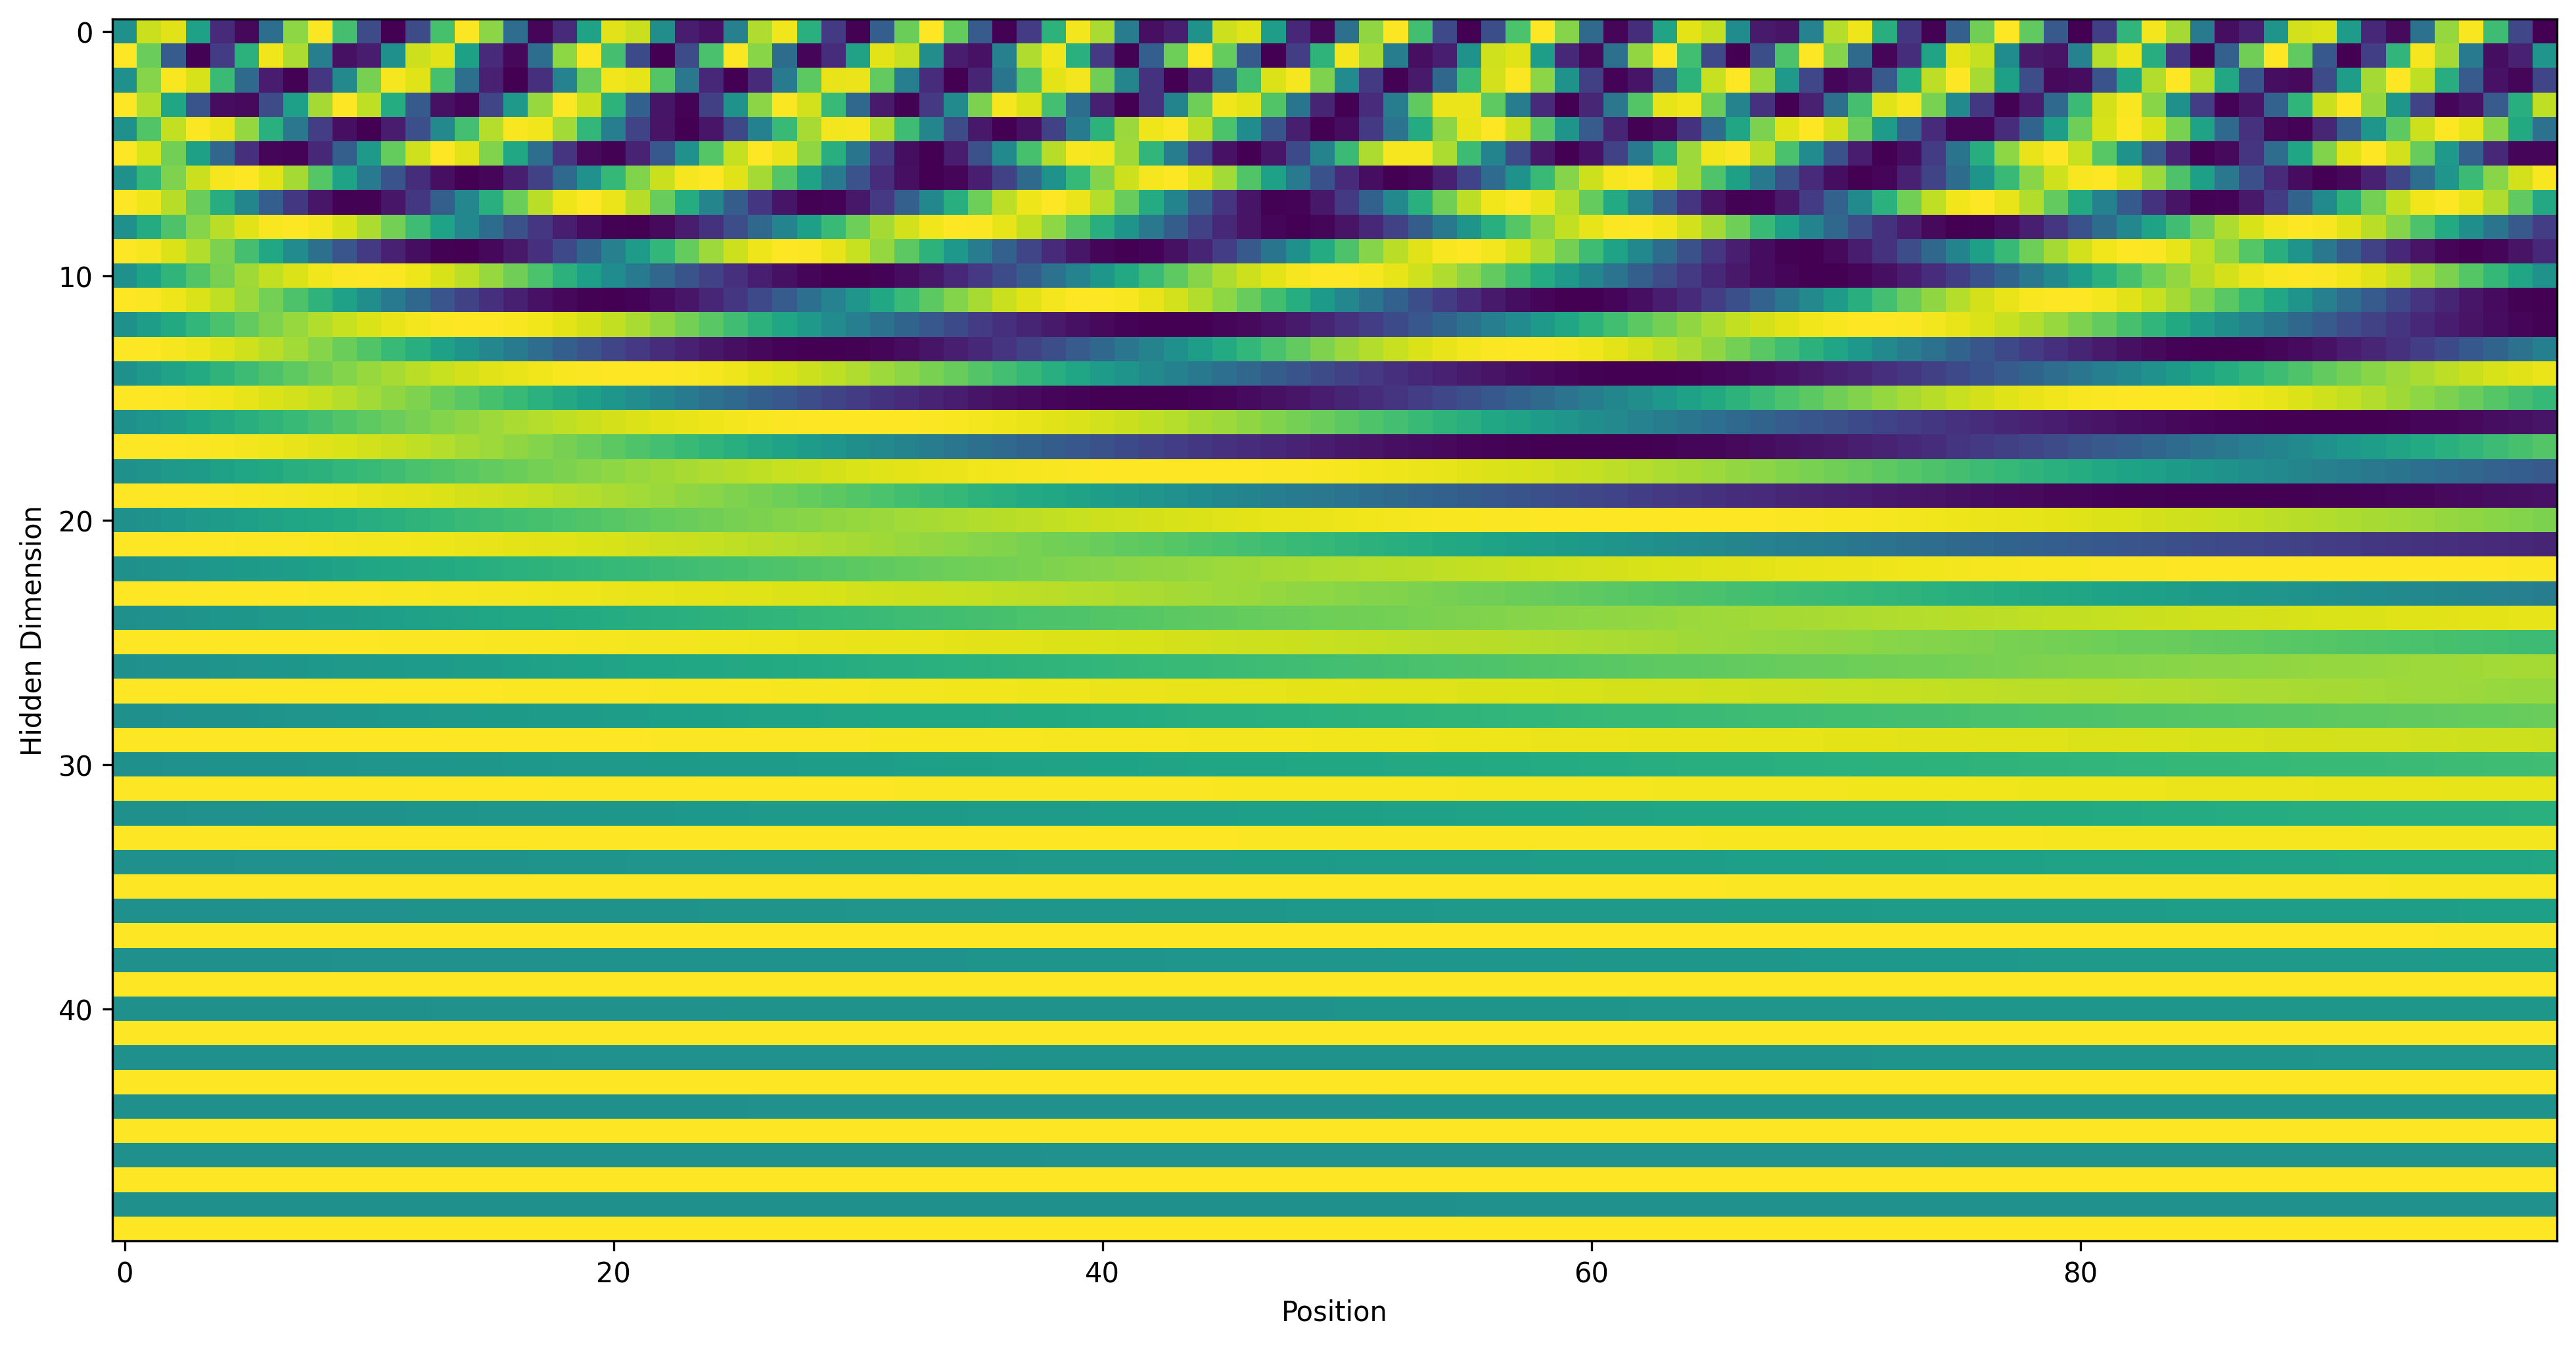

In [7]:
import matplotlib.pyplot as plt

pe=PositionalEncoding(50, 100).pe.squeeze().numpy().T
fig, ax=plt.subplots(1,1,figsize=(16,20), dpi=300)
pos = ax.imshow(pe)
ax.set_xlabel("Position")
ax.set_ylabel("Hidden Dimension")

# The Classification Model

In [8]:
class AntibodyClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        padding_idx,
        input_dim,
        num_layers,
        num_heads,
        dim_ffn,
        dropout,
        num_classes,
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, input_dim, padding_idx)
        self.pe = PositionalEncoding(input_dim)
        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=input_dim,
            num_head=num_heads,
            d_ffn=dim_ffn,
            dropout=dropout,
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.LeakyReLU(),
            nn.Linear(input_dim, num_classes),
        )

    def mean_pooling(
        self, token_embeddings: torch.Tensor, attention_mask: torch.Tensor
    ) -> torch.Tensor:
        """
        Average the embedding of all amino acids in a sequence.

        Args:
            token_embeddings (torch.Tensor): Token embeddings from the ESM model (bs, seq_len, embedding_dim).
            attention_mask (torch.Tensor): Attention mask (bs, seq_len).

        Returns:
            torch.Tensor: Mean-pooled embeddings (bs, embedding_dim).
        """

        # expand the mask
        expanded_mask = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.shape).float()
        )

        # sum unmasked token embeddings
        sum_embeddings = torch.sum(token_embeddings * expanded_mask, dim=1)

        # number of unmasked tokens for each sequence
        # set a min value to avoid divide by zero
        num_tokens = torch.clamp(expanded_mask.sum(1), min=1e-9)

        # divide
        mean_embeddings = sum_embeddings / num_tokens
        return mean_embeddings

    def forward(self, x, mask=None):
        # x: [batch, seq_len]
        x = self.embedding(x)  # [batch, seq_len, input_dim]
        x = self.pe(x)  # [batch, seq_len, input_dim]
        x = self.encoder(x, mask=mask)

        x = self.mean_pooling(x, mask)
        out = self.classifier(x)
        return out

model = AntibodyClassifier(
    vocab_size=tokenizer.vocab_size,
    padding_idx=tokenizer.pad_token_id,
    num_layers=8,
    input_dim=64,
    num_heads=2,
    dim_ffn=128,
    dropout=0.05,
    num_classes=2,
)

model.to("cuda")

AntibodyClassifier(
  (embedding): Embedding(24, 64, padding_idx=1)
  (pe): PositionalEncoding()
  (encoder): Encoder(
    (layers): ModuleList(
      (0-7): 8 x EncoderBlock(
        (attention): MultiheadAttention(
          (input): Linear(in_features=64, out_features=192, bias=True)
          (output): Linear(in_features=64, out_features=64, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.05, inplace=False)
          (3): Linear(in_features=128, out_features=64, bias=True)
        )
        (dropout): Dropout(p=0.05, inplace=False)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=

# Loading Dataset

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

bcr=pd.read_parquet("/kaggle/input/write-parquet-files-in-pandas/bcr.parquet")
le=LabelEncoder()
le.fit(bcr["target"])
bcr["label"]=le.transform(bcr["target"])
bcr.head()

,sequence,target,label
6229,EVQLVESGGGLVQPGGSLRLSCAASGFIVSSNYMTWVRQAPGKGLE...,SARS-CoV2,1
6920,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSFYIHWVRQAPGQGLE...,SARS-CoV2,1
6738,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSNYAISWVRQAPGQGLE...,SARS-CoV2,1
6582,EVQLVESGGGVVQPGRSLRISCAVSGFTFGSYAMHWVRQAPGKGLE...,SARS-CoV2,1
6401,QMQLVQSGTEVKKPGESLKISCKGSGYGFITYWIGWVRQMPGKGLE...,SARS-CoV2,1


In [10]:
from sklearn.model_selection import train_test_split

bcr_train, bcr_val = train_test_split(bcr, stratify=bcr["label"], random_state=0)
bcr_train["label"].mean(), bcr_val["label"].mean()

(0.5, 0.5)

In [11]:
bcr_train.reset_index(inplace=True, drop=True)
bcr_val.reset_index(inplace=True, drop=True)
bcr_train.head()

,sequence,target,label
0,VQLLEESGGGAVQPGRSLRLSCEASGFSFNSYGMHWVRQAPGKGLE...,SARS-CoV2,1
1,EGQLVQSGAELKKPGASVKISCKTSGYRFNFYHINWIRQTAGRGPE...,HIV-1,0
2,EVQLVESGGGLVQPGGSLRLSCAASGITVSSNYMNWVRQAPGKGLE...,SARS-CoV2,1
3,DRLFQSGGGVSRPGGSLRVNCGASGFTVRTHYMYWLRQSPGKGLEW...,HIV-1,0
4,QVQLVQSGAEVKKPGASVKVSCKVSGYTLPELSMHWVRQAPGKGLE...,SARS-CoV2,1


In [12]:
from torch.utils.data import Dataset

class BCRDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        x = self.df.loc[i, "sequence"]
        y = self.df.loc[i, "label"]

        return x, y

train_ds = BCRDataset(bcr_train)
val_ds = BCRDataset(bcr_val)

In [13]:
import functools
from torch.utils.data import DataLoader

def collate_fn(batch, tokenizer, device):
    seqs, labels = zip(*batch)

    batch = tokenizer(seqs, padding=True)

    # convert to tensor
    batch["input_ids"] = torch.tensor(
        batch["input_ids"], dtype=torch.long, device=device
    )
    batch["attention_mask"] = torch.tensor(
        batch["attention_mask"], dtype=torch.long, device=device
    )

    # labels
    batch["label"] = torch.tensor(labels, dtype=torch.long, device=device)
    return batch

collate_fn_partial = functools.partial(collate_fn, tokenizer=tokenizer, device="cuda")

train_dl = DataLoader(train_ds, collate_fn=collate_fn_partial, batch_size=8)
val_dl = DataLoader(val_ds, collate_fn=collate_fn_partial, batch_size=8)

train_batch = next(iter(train_dl))

print(train_batch["input_ids"].shape)
print(train_batch["attention_mask"].shape)
print(train_batch["label"].shape)

torch.Size([8, 245])
torch.Size([8, 245])
torch.Size([8])


In [14]:
model(train_batch["input_ids"], train_batch["attention_mask"]).shape

torch.Size([8, 2])

# Loss function and scheduler

In [15]:
from sklearn.metrics import roc_auc_score

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_step(model, train_dl, loss_fn, opt):
    model.train()

    losses = []
    for batch in train_dl:
        opt.zero_grad()
        y = model(batch["input_ids"], batch["attention_mask"])
        loss = loss_fn(y, batch["label"])
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return np.mean(losses)

def val_step(model, val_dl, loss_fn):
    model.eval()

    losses = []
    y_preds, y_true = [], []
    with torch.inference_mode():
        for batch in val_dl:
            y = model(batch["input_ids"], batch["attention_mask"])
            loss = loss_fn(y, batch["label"])
            losses.append(loss.item())
            y_preds.append(torch.softmax(y, dim=-1).cpu().numpy())
            y_true.append(batch["label"].cpu().numpy())

    return (np.mean(losses), np.vstack(y_preds), np.concatenate(y_true, axis=None))

In [16]:
import csv

def fit(model, train_dl, val_dl, loss_fn, opt, epochs, filename='train_history.csv'):
    with open(filename, 'w',newline='') as csvfile:
        csv_writter=csv.writer(csvfile)
        csv_writter.writerow(['Epoch', 'Train Loss', 'Valid Loss', 'Valid AUC Score'])
        
        for epoch in range(epochs):
            train_loss = train_step(model, train_dl, loss_fn, opt)
            val_loss, y_preds, y_true = val_step(model, val_dl, loss_fn)
            auc = roc_auc_score(y_true, y_preds[:, 1])
            
            csv_writter.writerow([epoch + 1, train_loss, val_loss, auc])
            
            print(
                f"Epoch: {epoch+1}; Train Loss: {train_loss}; Valid Loss: {val_loss}; Valid AUC Score: {auc}"
            )
        
fit(model, train_dl, val_dl, loss_fn, opt, 20)

Epoch: 1; Train Loss: 0.6924202844154003; Valid Loss: 0.6844209988911947; Valid AUC Score: 0.701138811942136
Epoch: 2; Train Loss: 0.6688635626504588; Valid Loss: 0.6758404612541199; Valid AUC Score: 0.7300707910126193
Epoch: 3; Train Loss: 0.6397047728993172; Valid Loss: 0.6950348834196727; Valid AUC Score: 0.7639273622653123
Epoch: 4; Train Loss: 0.6102192984070889; Valid Loss: 0.6419852395852407; Valid AUC Score: 0.7713142505386272
Epoch: 5; Train Loss: 0.5990486235119575; Valid Loss: 0.6353920777638753; Valid AUC Score: 0.7802400738688827
Epoch: 6; Train Loss: 0.5485854762238126; Valid Loss: 0.5560272792975108; Valid AUC Score: 0.7910126192674669
Epoch: 7; Train Loss: 0.5853910792705624; Valid Loss: 0.6661182423432668; Valid AUC Score: 0.786088027085257
Epoch: 8; Train Loss: 0.4974015219960102; Valid Loss: 0.5186769902706146; Valid AUC Score: 0.8128654970760234
Epoch: 9; Train Loss: 0.5048359140407207; Valid Loss: 0.5116420770684879; Valid AUC Score: 0.8153277931671283
Epoch: 10; T

# Credit

* https://towardsdatascience.com/building-transformer-models-for-proteins-from-scratch-60884eab5cc8
* https://github.com/naity/protein-transformer/tree/main
* https://jalammar.github.io/illustrated-transformer/